In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install tensorflow keras

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from sklearn.datasets import load_files
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
# from keras.utils import np_utils


(420, 479, 3)


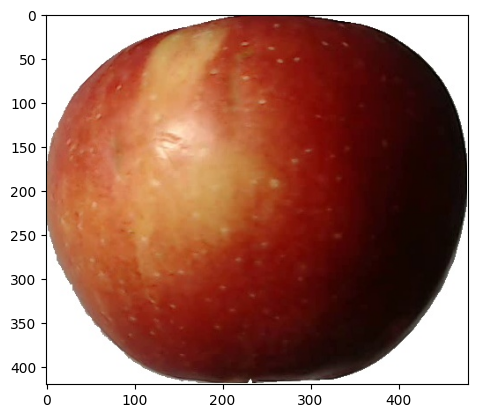

In [ ]:
img = mpimg.imread('/content/drive/MyDrive/fruit/fruits-360-original-size/Training/apple_braeburn_1/r0_0.jpg')
print(img.shape)
plt.imshow(img)

(412, 453, 3)


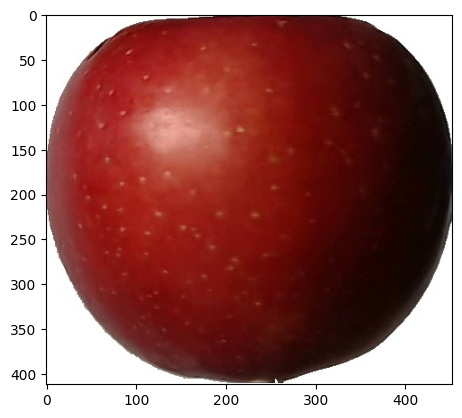

In [ ]:
img = mpimg.imread('/content/drive/MyDrive/fruit/fruits-360-original-size/Test/apple_braeburn_1/r0_103.jpg')
print(img.shape)
plt.imshow(img)

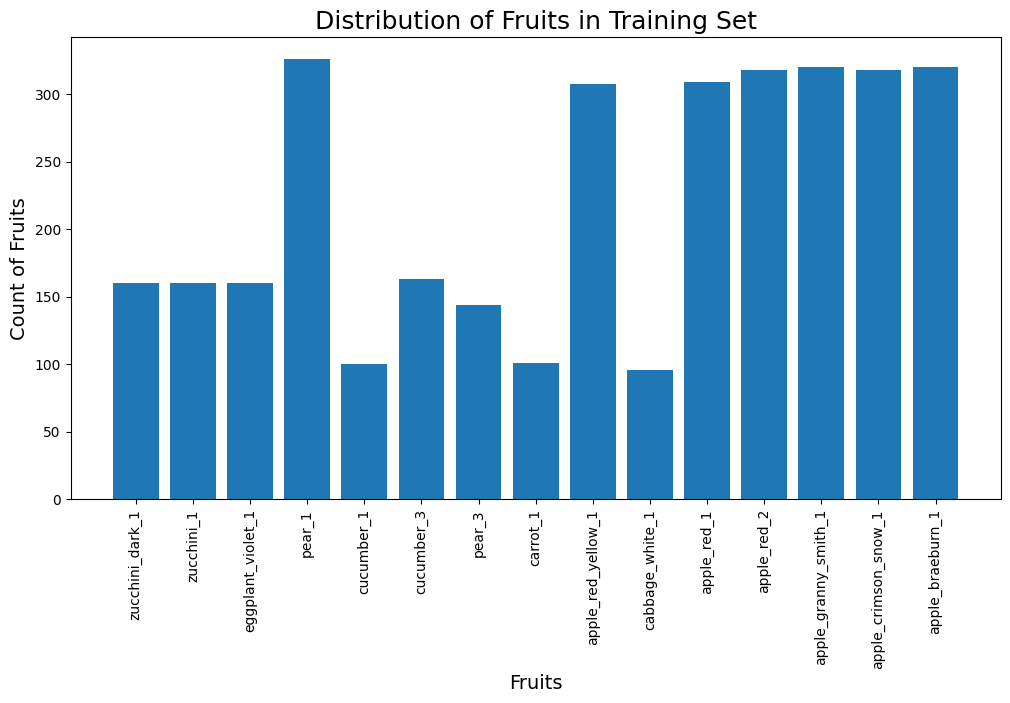

In [ ]:
figure_size = plt.rcParams["figure.figsize"]
figure_size[0] = 12   # chiều rộng
figure_size[1] = 6    # chiều cao
plt.rcParams["figure.figsize"] = figure_size

index = np.arange(len(train_categories))
plt.bar(index, train_samples)
plt.xlabel('Fruits', fontsize=14)
plt.ylabel('Count of Fruits', fontsize=14)
plt.xticks(index, train_categories, fontsize=10, rotation=90)
plt.title('Distribution of Fruits in Training Set', fontsize=18)
plt.show()


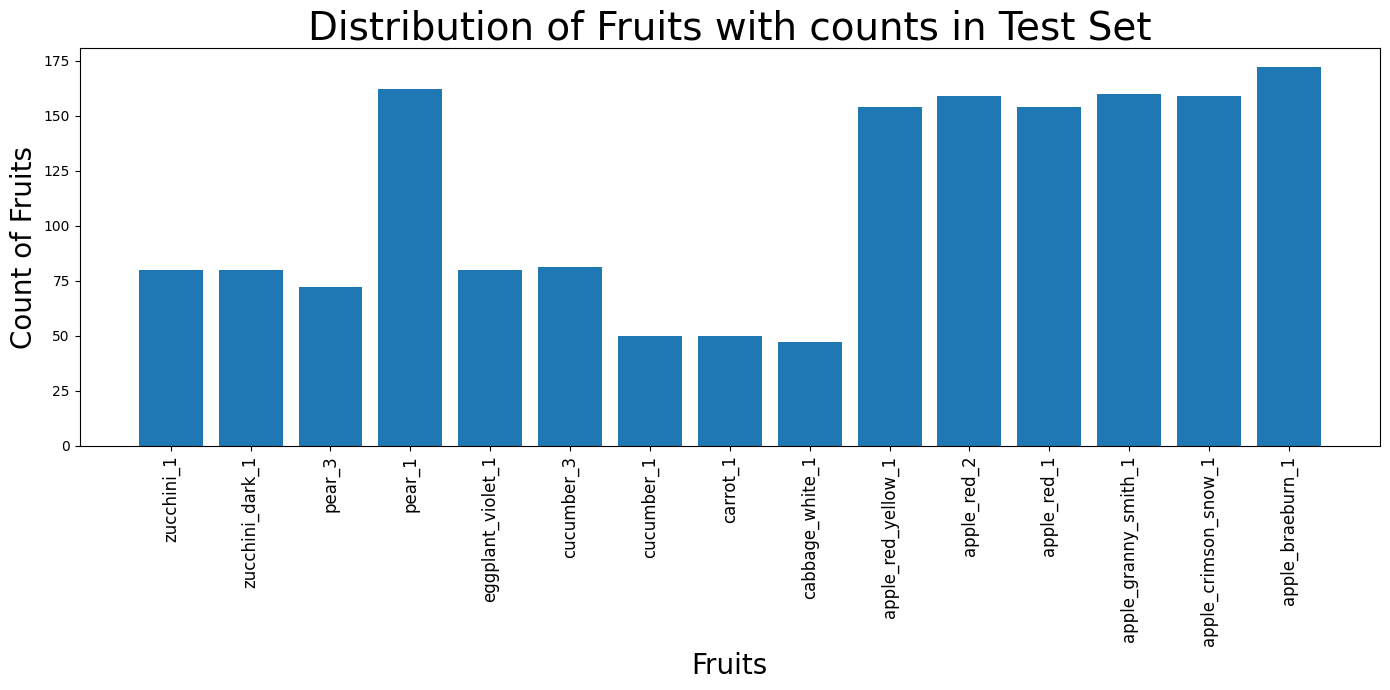

In [ ]:
plt.figure(figsize=(14, 7))

index2 = np.arange(len(test_categories))
plt.bar(index2, test_samples)
plt.xlabel('Fruits', fontsize=20)
plt.ylabel('Count of Fruits', fontsize=20)
plt.xticks(index2, test_categories, fontsize=12, rotation=90)
plt.title('Distribution of Fruits with counts in Test Set', fontsize=28)
plt.tight_layout()
plt.show()


<div class="alert alert-block alert-danger">  
<h2><center><strong>Data Preprocessing</strong></center></h2>
        
</div>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Đường dẫn
train_dir = '/content/drive/MyDrive/fruit/fruits-360-original-size/Training'
valid_dir = '/content/drive/MyDrive/fruit/fruits-360-original-size/Validation'
test_dir = '/content/drive/MyDrive/fruit/fruits-360-original-size/Test'

#Bộ sinh dữ liệu
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='constant',
    cval=255
)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

valid_gen = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical'
)


Found 3303 images belonging to 15 classes.
Found 1649 images belonging to 15 classes.
Found 1660 images belonging to 15 classes.


Kích thước batch ảnh: (32, 100, 100, 3)
Kích thước batch nhãn: (32, 15)


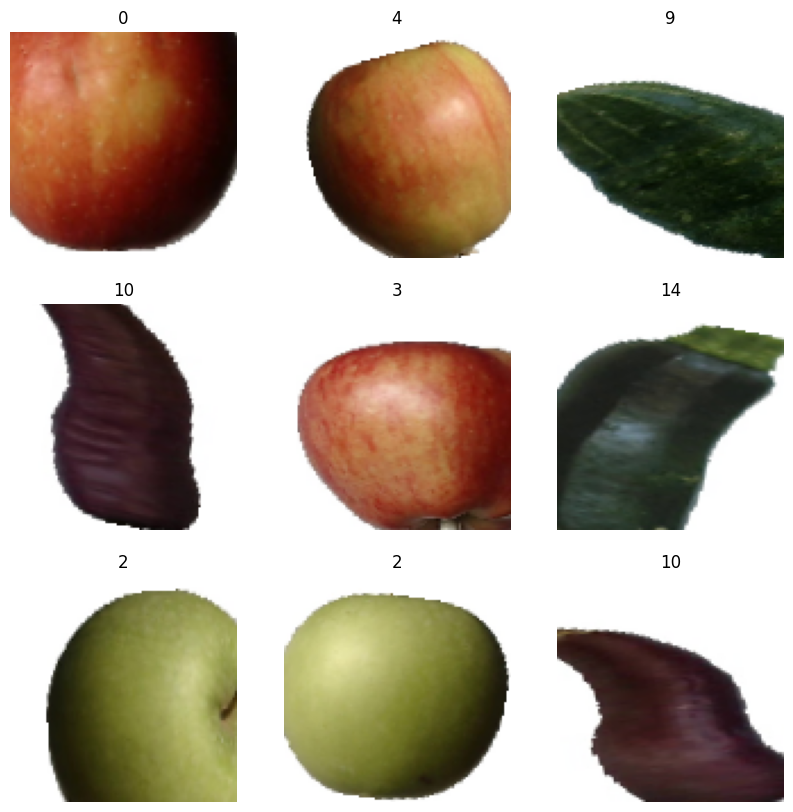

In [ ]:
images, labels = next(train_gen)

print("Kích thước batch ảnh:", images.shape)
print("Kích thước batch nhãn:", labels.shape)

# Hiển thị 9 ảnh đầu tiên trong batch
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(np.argmax(labels[i]))
    plt.axis('off')
plt.show()


<div class="alert alert-block alert-danger">  
<h2><center><strong>Xây dựng mô hình và huấn luyện </strong></center></h2>   
</div>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def cnn_intermediate_model():
    model = Sequential()
    # Tầng 1
    model.add(Conv2D(16, (3,3), activation='relu', input_shape=(100,100,3), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.2))
    # Tầng 2
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.2))
    # Tầng 3
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2))
    model.add(Dropout(0.2))
    # Fully connected
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(15, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

    return model

In [ ]:
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from google.colab import drive

# =======================
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/fruit/fruits-360-original-size'
os.makedirs(BASE_DIR, exist_ok=True)

MODEL_PATH = f'{BASE_DIR}/fruit_cnn_best.h5'

if os.path.exists(MODEL_PATH):
    print(" Đang tải lại mô hình từ checkpoint để tiếp tục huấn luyện...")
    model = load_model(MODEL_PATH)
else:
    print(" Tạo mô hình mới từ đầu...")
    model = cnn_intermediate_model()

checkpoint = ModelCheckpoint(
    MODEL_PATH, monitor='val_accuracy',
    save_best_only=True, verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5,
    restore_best_weights=True, verbose=1
)

callbacks = [checkpoint, early_stopping]

# BẮT ĐẦU HUẤN LUYỆN
EPOCHS = 20
print(f"Bắt đầu huấn luyện trong {EPOCHS} epoch")
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Tạo mô hình mới từ đầu...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Bắt đầu huấn luyện trong 20 epoch


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5204 - loss: 1.5662
Epoch 1: val_accuracy improved from -inf to 0.07884, saving model to /content/drive/MyDrive/fruit/fruits-360-original-size/fruit_cnn_best.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 1618s 16s/step - accuracy: 0.5219 - loss: 1.5607 - val_accuracy: 0.0788 - val_loss: 10.0754
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8458 - loss: 0.4462
Epoch 2: val_accuracy did not improve from 0.07884
104/104 ━━━━━━━━━━━━━━━━━━━━ 29s 281ms/step - accuracy: 0.8461 - loss: 0.4454 - val_accuracy: 0.0788 - val_loss: 14.5520
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9115 - loss: 0.2466
Epoch 3: val_accuracy did not improve from 0.07884
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - accuracy: 0.9116 - loss: 0.2464 - val_accuracy: 0.0788 - val_loss: 11.8950
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.9375 - loss: 0.1662
Epoch 4: val_accuracy improved from 0.07884 to 0.08247, saving model to /content/drive/MyDrive/fruit/fruits-360-original-size/fruit_cnn_best.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 30s 286ms/step - accuracy: 0.9376 - loss: 0.1662 - val_accuracy: 0.0825 - val_loss: 8.4057
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9499 - loss: 0.1356
Epoch 5: val_accuracy improved from 0.08247 to 0.53184, saving model to /content/drive/MyDrive/fruit/fruits-360-original-size/fruit_cnn_best.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 30s 293ms/step - accuracy: 0.9500 - loss: 0.1355 - val_accuracy: 0.5318 - val_loss: 1.9819
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9570 - loss: 0.1276
Epoch 6: val_accuracy improved from 0.53184 to 0.79442, saving model to /content/drive/MyDrive/fruit/fruits-360-original-size/fruit_cnn_best.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 30s 287ms/step - accuracy: 0.9570 - loss: 0.1275 - val_accuracy: 0.7944 - val_loss: 0.8116
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9771 - loss: 0.0769
Epoch 7: val_accuracy improved from 0.79442 to 0.91086, saving model to /content/drive/MyDrive/fruit/fruits-360-original-size/fruit_cnn_best.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 31s 297ms/step - accuracy: 0.9771 - loss: 0.0771 - val_accuracy: 0.9109 - val_loss: 0.2696
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9513 - loss: 0.1228
Epoch 8: val_accuracy did not improve from 0.91086
104/104 ━━━━━━━━━━━━━━━━━━━━ 29s 276ms/step - accuracy: 0.9515 - loss: 0.1225 - val_accuracy: 0.8866 - val_loss: 0.2938
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9786 - loss: 0.0705
Epoch 9: val_accuracy improved from 0.91086 to 0.99879, saving model to /content/drive/MyDrive/fruit/fruits-360-original-size/fruit_cnn_best.h5


104/104 ━━━━━━━━━━━━━━━━━━━━ 29s 284ms/step - accuracy: 0.9786 - loss: 0.0706 - val_accuracy: 0.9988 - val_loss: 0.0112
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9747 - loss: 0.0824
Epoch 10: val_accuracy did not improve from 0.99879
104/104 ━━━━━━━━━━━━━━━━━━━━ 29s 278ms/step - accuracy: 0.9747 - loss: 0.0824 - val_accuracy: 0.9109 - val_loss: 0.8023
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9759 - loss: 0.0621
Epoch 11: val_accuracy did not improve from 0.99879
104/104 ━━━━━━━━━━━━━━━━━━━━ 29s 280ms/step - accuracy: 0.9759 - loss: 0.0621 - val_accuracy: 0.9830 - val_loss: 0.0428
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9802 - loss: 0.0644
Epoch 12: val_accuracy did not improve from 0.99879
104/104 ━━━━━━━━━━━━━━━━━━━━ 29s 278ms/step - accuracy: 0.9802 - loss: 0.0644 - val_accuracy: 0.9321 - val_loss: 0.1780
Epoch 13/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9857 - loss: 0.0394
Epoch 13

104/104 ━━━━━━━━━━━━━━━━━━━━ 29s 281ms/step - accuracy: 0.9896 - loss: 0.0361 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 15/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9882 - loss: 0.0406
Epoch 15: val_accuracy did not improve from 1.00000
104/104 ━━━━━━━━━━━━━━━━━━━━ 29s 280ms/step - accuracy: 0.9882 - loss: 0.0406 - val_accuracy: 0.9933 - val_loss: 0.0158
Epoch 16/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9873 - loss: 0.0394
Epoch 16: val_accuracy did not improve from 1.00000
104/104 ━━━━━━━━━━━━━━━━━━━━ 28s 274ms/step - accuracy: 0.9873 - loss: 0.0394 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 17/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9845 - loss: 0.0435
Epoch 17: val_accuracy did not improve from 1.00000
104/104 ━━━━━━━━━━━━━━━━━━━━ 32s 313ms/step - accuracy: 0.9844 - loss: 0.0436 - val_accuracy: 0.9861 - val_loss: 0.0358
Epoch 18/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.9879 - loss: 0.0279
Epoch 18

In [ ]:
# print("\n Đang đánh giá trên tập test...")
# test_loss, test_acc = model.evaluate(test_gen, verbose=1)
# print(f" Độ chính xác trên tập test: {test_acc:.4f}")
# print(f" Mất mát trên tập test: {test_loss:.4f}")

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# --- Đường dẫn ---
MODEL_PATH = '/content/drive/MyDrive/fruit/fruits-360-original-size/fruit_cnn_best.h5'
test_dir = '/content/drive/MyDrive/fruit/fruits-360-original-size/Test'

# -- Load lại mô hình đã huấn luyện ---
model = load_model(MODEL_PATH)

# --- Tạo lại test generator (đọc ảnh mới thêm) ---
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Không shuffle để giữ thứ tự khi đánh giá
)

# --- 4️⃣ Đánh giá lại ---
print("\nĐang đánh giá trên tập test...")
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"\n Độ chính xác trên tập test: {test_acc:.4f}")
print(f"Mất mát (loss) trên tập test: {test_loss:.4f}")


Found 1669 images belonging to 15 classes.

📊 Đang đánh giá trên tập test...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 412s 8s/step - accuracy: 0.9972 - loss: 0.0578

✅ Độ chính xác trên tập test: 0.9964
📉 Mất mát (loss) trên tập test: 0.0669


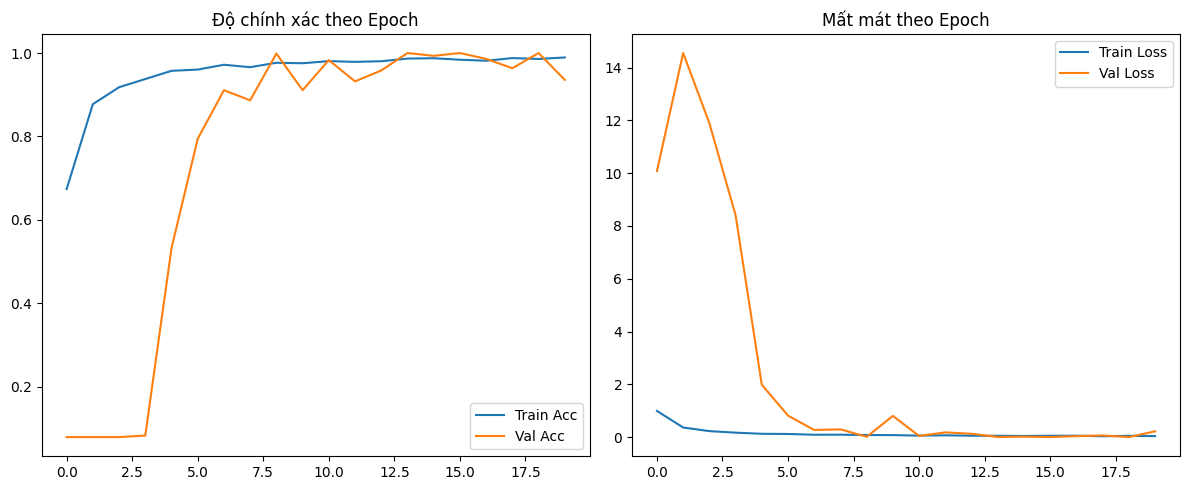

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Độ chính xác theo Epoch')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Mất mát theo Epoch')

plt.tight_layout()
plt.savefig(f"{BASE_DIR}/training_curves.png")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Found 3303 images belonging to 15 classes.


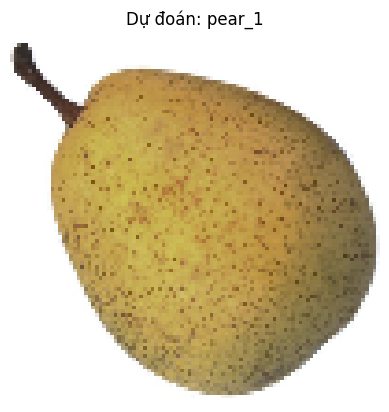

✅ Dự đoán: pear_1


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# --- 1️⃣ Tải mô hình đã huấn luyện ---
MODEL_PATH = '/content/drive/MyDrive/fruit/fruits-360-original-size/fruit_cnn_best.h5'
model = load_model(MODEL_PATH)

# --- 2️⃣ Đường dẫn đến ảnh cần dự đoán ---
img_path = '/content/drive/MyDrive/fruit/fruits-360-original-size/alexander_lucas_pear_seite_1_1.jpg'  # ← thay đường dẫn của bạn

# --- 3️⃣ Tiền xử lý ảnh (giống lúc huấn luyện) ---
img = image.load_img(img_path, target_size=(100, 100))  # resize giống train_gen
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # thêm chiều batch
img_array = img_array / 255.0  # chuẩn hóa giống ImageDataGenerator

# --- 4️⃣ Dự đoán ---
pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)[0]

# --- 5️⃣ Lấy tên lớp từ generator ---
# Lưu ý: bạn cần load lại generator để lấy class_indices
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/MyDrive/fruit/fruits-360-original-size/Training'
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen = train_datagen.flow_from_directory(train_dir, target_size=(100,100), batch_size=32, class_mode='categorical')

class_indices = {v: k for k, v in train_gen.class_indices.items()}
pred_label = class_indices[pred_class]

# --- 6️⃣ Hiển thị kết quả ---
plt.imshow(img)
plt.title(f"Dự đoán: {pred_label}")
plt.axis('off')
plt.show()

print(f"✅ Dự đoán: {pred_label}")


# Model compilation

In [ ]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

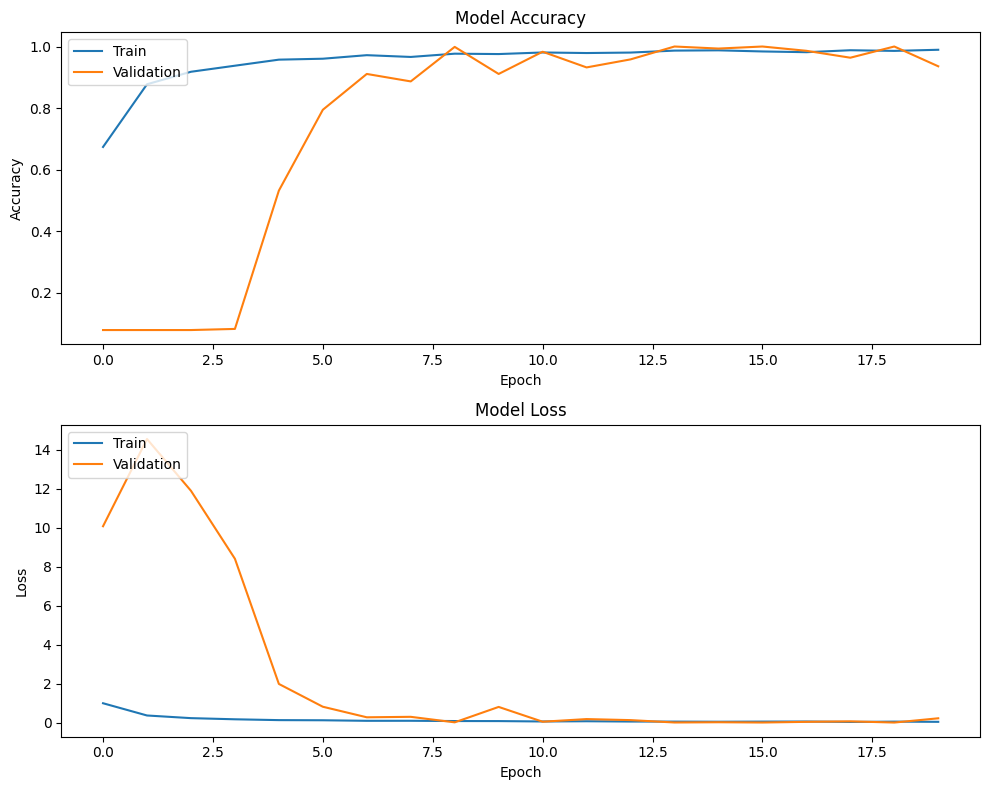

In [ ]:
import matplotlib.pyplot as plt

plt.figure(1, figsize=(10, 8))

# --- Biểu đồ độ chính xác ---
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# --- Biểu đồ mất mát ---
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
